Training Model...
Epoch 0, Loss: 42.6247
Epoch 50, Loss: 40.7570
Epoch 100, Loss: 38.7079
Epoch 150, Loss: 36.0310
Epoch 200, Loss: 32.5817
Epoch 250, Loss: 28.2310
Epoch 300, Loss: 23.1531
Epoch 350, Loss: 18.3897
Epoch 400, Loss: 14.0224
Epoch 450, Loss: 11.2045
Epoch 500, Loss: 9.9223
Epoch 550, Loss: 9.5249
Epoch 600, Loss: 9.0186
Epoch 650, Loss: 8.7452
Epoch 700, Loss: 8.4801
Epoch 750, Loss: 8.6158
Epoch 800, Loss: 8.2889
Epoch 850, Loss: 8.1479
Epoch 900, Loss: 8.2292
Epoch 950, Loss: 7.9032

Final Test MAE: 9.0655
Final Test MSE: 556.4958
R² Score: 0.6959
Root MSE: 23.5902
Mean Absolute Percentage Accuracy: 83.61%


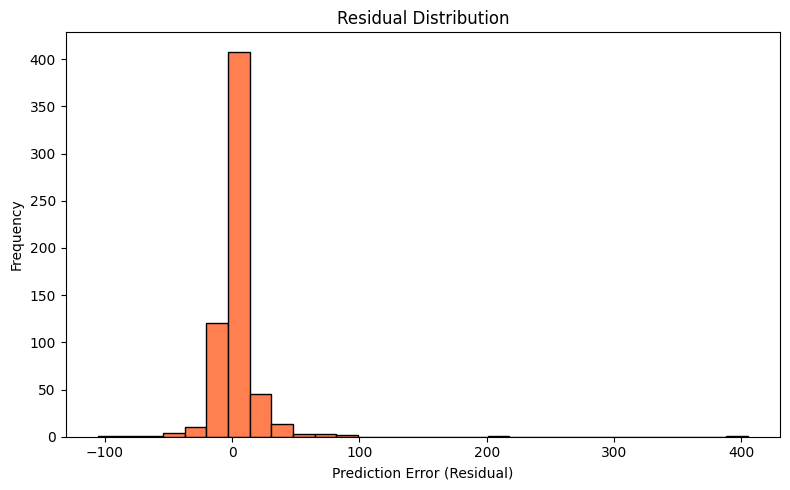

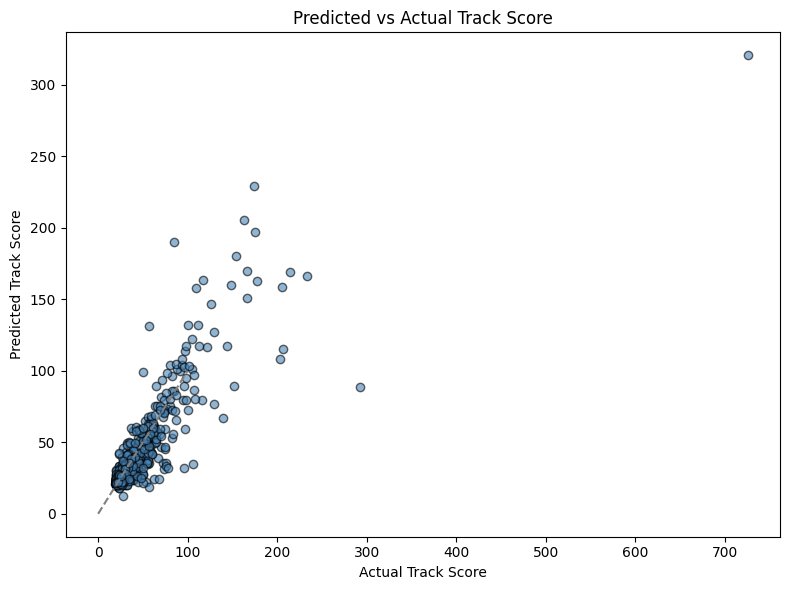

Exported predictions to 'track_score_predictions.csv'


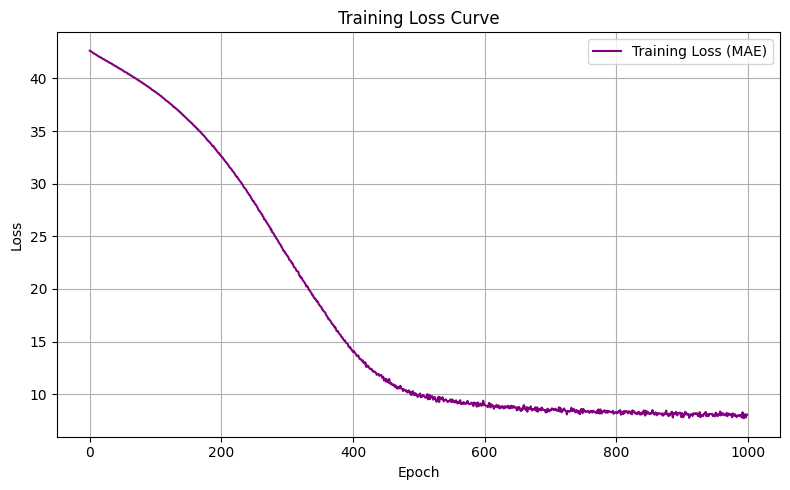

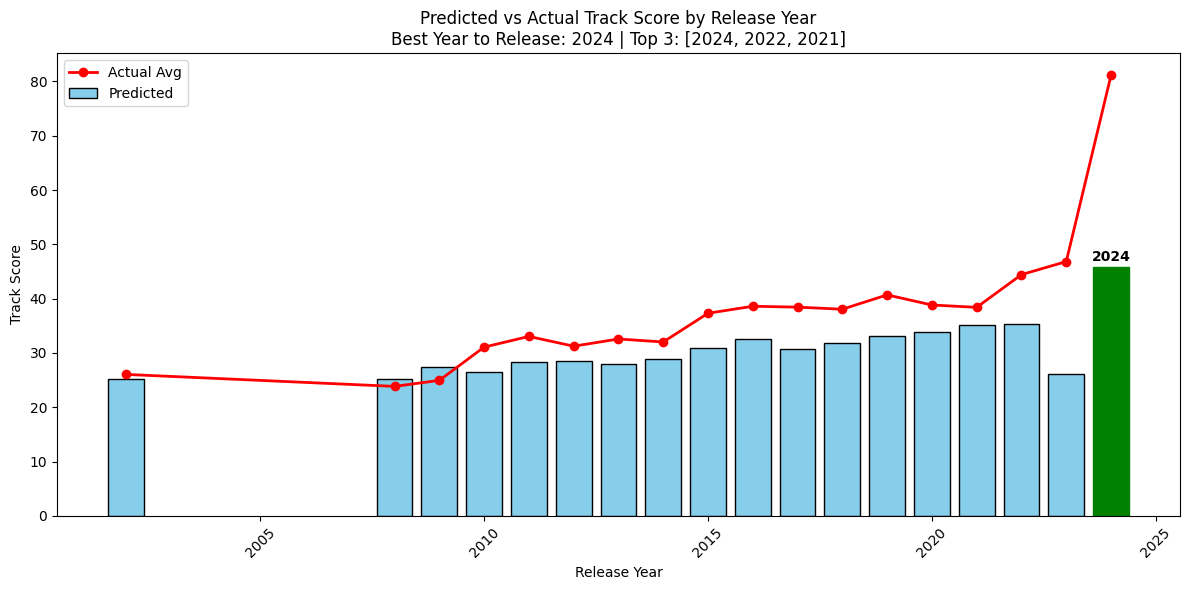

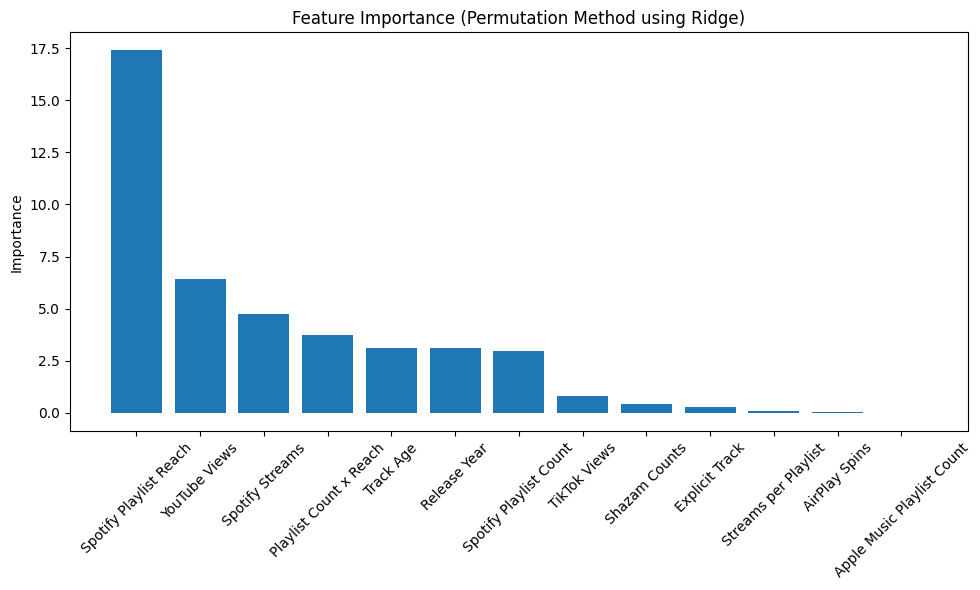

In [27]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Load Dataset
csv_path = "Spotify_Data.csv"
df = pd.read_csv(csv_path, encoding='latin1')

# ============================
# Data Cleaning & Feature Engineering
# ============================
df['Release Date'] = pd.to_datetime(df['Release Date'], errors='coerce')
df['Release Year'] = df['Release Date'].dt.year

# Clean numeric columns before feature engineering
df['Spotify Playlist Count'] = df['Spotify Playlist Count'].astype(str).str.replace(',', '', regex=False)
df['Spotify Playlist Reach'] = df['Spotify Playlist Reach'].astype(str).str.replace(',', '', regex=False)
df['Spotify Streams'] = df['Spotify Streams'].astype(str).str.replace(',', '', regex=False)

# Convert to numeric
for col in ['Spotify Playlist Count', 'Spotify Playlist Reach', 'Spotify Streams']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Derived Features
df['Track Age'] = 2025 - df['Release Year']
df['Playlist Count x Reach'] = df['Spotify Playlist Count'] * df['Spotify Playlist Reach']
df['Streams per Playlist'] = df['Spotify Streams'] / (df['Spotify Playlist Count'] + 1)

# Base + Engineered Feature Columns
feature_cols = [
    'Release Year', 'Track Age', 'Spotify Playlist Count', 'Spotify Playlist Reach', 'Explicit Track',
    'Spotify Streams', 'YouTube Views', 'TikTok Views',
    'Apple Music Playlist Count', 'AirPlay Spins', 'Shazam Counts',
    'Playlist Count x Reach', 'Streams per Playlist'
]

# Add target
df['Track Score'] = pd.to_numeric(df['Track Score'], errors='coerce')

# Clean and convert all relevant columns to numeric
for col in feature_cols:
    df[col] = df[col].astype(str).str.replace(',', '', regex=False)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Log-transform skewed features
skewed_cols = [
    'Spotify Streams', 'YouTube Views', 'TikTok Views',
    'Apple Music Playlist Count', 'AirPlay Spins', 'Shazam Counts'
]
for col in skewed_cols:
    df[col] = np.log1p(df[col])

# Drop NA
df = df.dropna(subset=['Track Score'] + feature_cols)

# Filter out years with too little data
year_counts = df['Release Year'].value_counts()
df = df[df['Release Year'].isin(year_counts[year_counts >= 5].index)]

# ==========================
# Feature Preparation
# ==========================
X = df[feature_cols].fillna(0)
y = df['Track Score']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# ==========================
# Define Neural Network
# ==========================
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(X_train.shape[1], 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        return self.fc3(x)

model = Net()
criterion = nn.L1Loss()  # Switch to MAE for better real-world accuracy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ==========================
# Training
# ==========================
print("Training Model...")
losses = []  # Initialize list to track training loss
for epoch in range(1000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())  # Track each epoch's loss
    if epoch % 50 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

# ==========================
# Evaluation
# ==========================
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    mae = criterion(predictions, y_test)
    y_true = y_test.numpy().flatten()
    y_pred = predictions.numpy().flatten()
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mse)
    accuracy = 100 - np.mean(np.abs((y_true - y_pred) / y_true) * 100)

    print(f"\nFinal Test MAE: {mae.item():.4f}")
    print(f"Final Test MSE: {mse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"Root MSE: {rmse:.4f}")
    print(f"Mean Absolute Percentage Accuracy: {accuracy:.2f}%")

    # Residual plot
    residuals = y_true - y_pred
    plt.figure(figsize=(8, 5))
    plt.hist(residuals, bins=30, edgecolor='black', color='coral')
    plt.title('Residual Distribution')
    plt.xlabel('Prediction Error (Residual)')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Scatter: predicted vs actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.6, color='steelblue', edgecolor='k')
    plt.plot([0, 100], [0, 100], linestyle='--', color='gray')
    plt.xlabel('Actual Track Score')
    plt.ylabel('Predicted Track Score')
    plt.title('Predicted vs Actual Track Score')
    plt.tight_layout()
    plt.show()

    # Export predictions
    results_df = pd.DataFrame({
        'Actual Track Score': y_true,
        'Predicted Track Score': y_pred
    })
    results_df.to_csv('track_score_predictions.csv', index=False)
    print("Exported predictions to 'track_score_predictions.csv'")

    # ==========================
    # Loss Curve
    # ==========================
    plt.figure(figsize=(8, 5))
    plt.plot(losses, label='Training Loss (MAE)', color='purple')
    plt.title('Training Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==========================
    # Predicted vs Actual by Release Year
    # ==========================
    grouped = df.groupby('Release Year')
    mean_features = grouped[feature_cols].mean()
    mean_features = mean_features.copy()
    mean_features['Release Year'] = mean_features.index
    yearly_means = mean_features.reset_index(drop=True)

    years = yearly_means['Release Year'].tolist()
    predicted_scores = []

    for _, row in yearly_means.iterrows():
        features = [row[col] for col in feature_cols]
        scaled = scaler.transform(pd.DataFrame([features], columns=feature_cols))
        tensor_input = torch.tensor(scaled, dtype=torch.float32)
        with torch.no_grad():
            pred = model(tensor_input).item()
        predicted_scores.append(pred)

    actual_scores = df.groupby('Release Year')['Track Score'].mean().reindex(years).values
    best_year = years[np.argmax(predicted_scores)]
    top_3_years = [years[i] for i in np.argsort(predicted_scores)[-3:][::-1]]

    colors = ['orange' if year == best_year else 'skyblue' for year in years]
    plt.figure(figsize=(12, 6))
    bars = plt.bar(years, predicted_scores, color=colors, edgecolor='black', label='Predicted')
    plt.plot(years, actual_scores, color='red', marker='o', linewidth=2, label='Actual Avg')

    # Annotate best year
    best_index = years.index(best_year)
    bars[best_index].set_color('green')
    plt.text(years[best_index], predicted_scores[best_index] + 1,
             f"{best_year}", ha='center', color='black', fontweight='bold')

    plt.title(f'Predicted vs Actual Track Score by Release Year\nBest Year to Release: {best_year} | Top 3: {top_3_years}')
    plt.xlabel('Release Year')
    plt.ylabel('Track Score')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

     # ==========================
    # Feature Importance via Permutation
    # ==========================
    from sklearn.inspection import permutation_importance
    from sklearn.linear_model import Ridge

    # Fit a surrogate model on the same data
    ridge = Ridge()
    ridge.fit(X_scaled, y)

    result = permutation_importance(
        ridge,
        X_scaled,
        y,
        scoring='neg_mean_absolute_error',
        n_repeats=10,
        random_state=42
    )

    importances = result.importances_mean
    sorted_idx = np.argsort(importances)[::-1]

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(feature_cols)), importances[sorted_idx], align='center')
    plt.xticks(range(len(feature_cols)), [feature_cols[i] for i in sorted_idx], rotation=45)
    plt.title('Feature Importance (Permutation Method using Ridge)')
    plt.ylabel('Importance')
    plt.tight_layout()
    plt.show()

